In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.parallel import DataParallel
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
class TVARNet(nn.Module):
    def __init__(self, seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128):
        """
        Args:
            seq_len: Length of input sequence
            n_classes: Number of AR order classes (5 for p∈{2,3,4,5,6})
            max_ar_order: Maximum AR order for coefficient output (6 for AR(6))
            hidden_dim: Hidden layer dimension
        """
        super().__init__()
        self.seq_len = seq_len
        self.n_classes = n_classes
        self.max_ar_order = max_ar_order
        
        # P-Block: predicts order class (n_classes outputs)
        self.p_block = nn.Sequential(
            nn.Linear(seq_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_classes)
        )
        
        # D-Block: (N, seq_len + n_classes) -> (N, seq_len * max_ar_order)
        self.d_block = nn.Sequential(
            nn.Linear(seq_len + n_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, seq_len * max_ar_order)
        )
    
    def forward(self, x, temperature=1.0):
        # x: (N, seq_len)
        N = x.shape[0]
        
        # P-Block: predict class (0 to n_classes-1)
        p_logits = self.p_block(x)  # (N, n_classes)
        p_soft = F.gumbel_softmax(p_logits, tau=temperature, hard=True)  # (N, n_classes)
        p_hard = torch.argmax(p_soft, dim=-1)  # (N,) values in [0, n_classes-1]
        
        # Convert class to AR order: class 0 -> p=2, class 4 -> p=6
        # So we need (p_hard + 2) coefficients active
        # Mask: indices 0...(p_hard+1) should be active
        indices = torch.arange(self.max_ar_order, device=x.device).unsqueeze(0)  # (1, max_ar_order)
        mask = (indices <= p_hard.unsqueeze(1) + 1).float()  # (N, max_ar_order)
        
        # D-Block: concat x and p_soft
        d_input = torch.cat([x, p_soft], dim=1)  # (N, seq_len + n_classes)
        coeffs_raw = self.d_block(d_input)  # (N, seq_len * max_ar_order)
        coeffs_raw = coeffs_raw.view(N, self.seq_len, self.max_ar_order)  # (N, seq_len, max_ar_order)
        
        # Apply mask
        coeffs = coeffs_raw * mask.unsqueeze(1)  # (N, seq_len, max_ar_order)
        
        # Vectorized AR: build lag matrix and do batch matmul
        # x_lagged[:, t, k] = x[:, t - k - 1]
        x_lagged = torch.zeros(N, self.seq_len, self.max_ar_order, device=x.device)
        for k in range(self.max_ar_order):
            x_lagged[:, k+1:, k] = x[:, :self.seq_len - k - 1]
        
        # x_hat[n, t] = sum_k coeffs[n, t, k] * x_lagged[n, t, k]
        x_hat = (coeffs * x_lagged).sum(dim=-1)  # (N, seq_len)
        
        return coeffs, p_logits, p_hard, x_hat


In [3]:
def loss_p(p_logits, p_true):
    return F.cross_entropy(p_logits, p_true)

def loss_ar(x, x_hat, p_max):
    return F.mse_loss(x_hat[:, p_max:], x[:, p_max:])

def loss_energy(x_hat, P0=0.5, W=40):
    # Use unfold for sliding window
    N, T = x_hat.shape
    # Pad at start so we get T windows
    x_padded = F.pad(x_hat, (W - 1, 0), mode='constant', value=0)
    windows = x_padded.unfold(1, W, 1)  # (N, T, W)
    powers = (windows ** 2).mean(dim=-1)  # (N, T)
    return ((powers - P0) ** 2).mean()

def loss_smooth(coeffs):
    diff = coeffs[:, 1:, :] - coeffs[:, :-1, :]
    return torch.mean(torch.sum(diff ** 2, dim=2))

def loss_order(p_logits):
    """Regularizer to prefer lower AR orders.
    Computes expected order index from softmax probabilities and penalizes higher values.
    """
    # p_logits: (N, n_classes) where class 0 -> p=2, class 4 -> p=6
    n_classes = p_logits.shape[1]
    probs = F.softmax(p_logits, dim=-1)  # (N, n_classes)
    indices = torch.arange(n_classes, device=p_logits.device, dtype=p_logits.dtype)  # [0, 1, 2, 3, 4]
    expected_order = (probs * indices).sum(dim=-1)  # (N,) expected class index
    return expected_order.mean()  # Minimize expected order

In [4]:
def load_dataset_npz(path):
    d = np.load(path, allow_pickle=True)
    return {
        "X": d["X"],
        "A": d["A"],
        "p_true": d["p_true"],
        "class_id": d["class_id"],
        "class_names": d["class_names"],
        "noise_std": d["noise_std"],
        "meta": list(d["meta"]),
    }

def pinn_processor(npz_path, p_min=1):
    """
    Load a saved TVAR benchmark dataset and return arrays ready for training.
    
    Args
    ----
    npz_path : str
        Path to the .npz file saved by save_dataset_npz().
    p_min : int
        Minimum AR order used when generating the dataset. 
        Used to compute 0-indexed class labels for cross entropy.
    
    Returns
    -------
    X : array, shape [N, T]
        Time series samples.
    coeffs : array, shape [N, T, p_max]
        Time-varying AR coefficients (actual, after power control).
    p_true : array, shape [N]
        True AR order for each sample, 0-indexed (p_true_raw - p_min) for cross entropy.
    """
    dataset = load_dataset_npz(npz_path)
    
    X = dataset["X"]              # [N, T]
    coeffs = dataset["A"]         # [N, T, p_max]
    p_true_raw = dataset["p_true"]  # [N], actual AR orders (e.g., 1, 2, 4, 6)
    
    # Convert p_true to 0-indexed labels for cross entropy loss
    # Map unique p values to consecutive indices
    unique_p = np.sort(np.unique(p_true_raw))
    p_to_idx = {int(p): i for i, p in enumerate(unique_p)}
    p_true = np.array([p_to_idx[int(p)] for p in p_true_raw], dtype=np.int64)
    
    return X, coeffs, p_true




In [5]:
# Generate data
data = "/Users/novak/Documents/UTSW/erfan/StocasticDiffEq_Simulation/ref/tvar_pinn_test.npz"
X_train, coef_train, p_train = pinn_processor(data)
X_val, coef_val, p_val = pinn_processor(data)

# np.savez_compressed('model/tvar_dataset.npz',
#                     X_train=X_train, coef_train=coef_train, p_train=p_train,
#                     X_val=X_val, coef_val=coef_val, p_val=p_val)

# d = np.load('model/tvar_dataset.npz')
# X_train, coef_train, \
#     p_train, X_val, coef_val, p_val = [d[k][:] for k in ['X_train', 'coef_train', 
#                                                       'p_train', 'X_val', 'coef_val', 'p_val']]
# d.close()


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.init()
print(f"Using device: {device}")

# To tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
p_train = torch.tensor(p_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
p_val = torch.tensor(p_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, p_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, p_val), batch_size=32)

# Model: n_classes=5 for p∈{2,3,4,5,6}, max_ar_order=6 for coefficient dimensions
model = TVARNet(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
# model = DataParallel(model)
model = model.to(device)

Using device: cpu


In [7]:
summary(model, input_size=(32, 600), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
TVARNet                                  [32, 600, 6]              --
├─Sequential: 1-1                        [32, 5]                   --
│    └─Linear: 2-1                       [32, 128]                 76,928
│    └─ReLU: 2-2                         [32, 128]                 --
│    └─Linear: 2-3                       [32, 128]                 16,512
│    └─ReLU: 2-4                         [32, 128]                 --
│    └─Linear: 2-5                       [32, 5]                   645
├─Sequential: 1-2                        [32, 3600]                --
│    └─Linear: 2-6                       [32, 128]                 77,568
│    └─ReLU: 2-7                         [32, 128]                 --
│    └─Linear: 2-8                       [32, 128]                 16,512
│    └─ReLU: 2-9                         [32, 128]                 --
│    └─Linear: 2-10                      [32, 3600]                4

In [8]:
def train(
    model,
    train_loader,
    val_loader,
    n_epochs=100,
    lr=1e-3,
    lambda_p=10.0,
    lambda_ar=1.0,
    lambda_energy=0.1,
    lambda_smooth=0.05,
    lambda_order=0.0,
    P0=0.5,
    W=40,
    p_max=6,
    device='cuda'
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    history = {
        'train_loss': [], 'train_p': [], 'train_ar': [], 'train_energy': [], 'train_smooth': [], 'train_order': [], 'train_p_acc': [],
        'val_loss': [], 'val_p': [], 'val_ar': [], 'val_energy': [], 'val_smooth': [], 'val_order': [], 'val_p_acc': []
    }
    
    pbar = tqdm(total=n_epochs, desc='Training')
    for epoch in range(n_epochs):
        # Train
        model.train()
        train_losses = {'total': [], 'p': [], 'ar': [], 'energy': [], 'smooth': [], 'order': []}
        train_correct = 0
        train_total = 0
        
        for x_batch, p_batch in train_loader:
            x_batch = x_batch.to(device)
            p_batch = p_batch.to(device)
            
            optimizer.zero_grad()
            
            coeffs, p_logits, p_hard, x_hat = model(x_batch)
            
            l_p = loss_p(p_logits, p_batch)
            l_ar = loss_ar(x_batch, x_hat, p_max)
            l_energy = loss_energy(x_hat, P0, W)
            l_smooth = loss_smooth(coeffs)
            l_order = loss_order(p_logits)
            
            total_loss = lambda_p * l_p + lambda_ar * l_ar + lambda_energy * l_energy + lambda_smooth * l_smooth + lambda_order * l_order
            
            total_loss.backward()
            optimizer.step()
            
            train_losses['total'].append(total_loss.item())
            train_losses['p'].append(l_p.item())
            train_losses['ar'].append(l_ar.item())
            train_losses['energy'].append(l_energy.item())
            train_losses['smooth'].append(l_smooth.item())
            train_losses['order'].append(l_order.item())
            
            train_correct += (p_hard == p_batch).sum().item()
            train_total += p_batch.shape[0]
        
        # Validate
        model.eval()
        val_losses = {'total': [], 'p': [], 'ar': [], 'energy': [], 'smooth': [], 'order': []}
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for x_batch, p_batch in val_loader:
                x_batch = x_batch.to(device)
                p_batch = p_batch.to(device)
                
                coeffs, p_logits, p_hard, x_hat = model(x_batch)
                
                l_p = loss_p(p_logits, p_batch)
                l_ar = loss_ar(x_batch, x_hat, p_max)
                l_energy = loss_energy(x_hat, P0, W)
                l_smooth = loss_smooth(coeffs)
                l_order = loss_order(p_logits)
                
                total_loss = lambda_p * l_p + lambda_ar * l_ar + lambda_energy * l_energy + lambda_smooth * l_smooth + lambda_order * l_order
                
                val_losses['total'].append(total_loss.item())
                val_losses['p'].append(l_p.item())
                val_losses['ar'].append(l_ar.item())
                val_losses['energy'].append(l_energy.item())
                val_losses['smooth'].append(l_smooth.item())
                val_losses['order'].append(l_order.item())
                
                val_correct += (p_hard == p_batch).sum().item()
                val_total += p_batch.shape[0]
        
        history['train_loss'].append(np.mean(train_losses['total']))
        history['train_p'].append(np.mean(train_losses['p']))
        history['train_ar'].append(np.mean(train_losses['ar']))
        history['train_energy'].append(np.mean(train_losses['energy']))
        history['train_smooth'].append(np.mean(train_losses['smooth']))
        history['train_order'].append(np.mean(train_losses['order']))
        history['train_p_acc'].append(train_correct / train_total)
        
        history['val_loss'].append(np.mean(val_losses['total']))
        history['val_p'].append(np.mean(val_losses['p']))
        history['val_ar'].append(np.mean(val_losses['ar']))
        history['val_energy'].append(np.mean(val_losses['energy']))
        history['val_smooth'].append(np.mean(val_losses['smooth']))
        history['val_order'].append(np.mean(val_losses['order']))
        history['val_p_acc'].append(val_correct / val_total)
        
        scheduler.step(history['val_loss'][-1])
        
        
        pbar.update(1)
        pbar.set_postfix(
            train=f"{history['train_loss'][-1]:.4f}",
            val=f"{history['val_loss'][-1]:.4f}",
            p_acc=f"{history['val_p_acc'][-1]:.3f}"
        )
    
    pbar.close()
    return history

In [9]:
# hyperparameters
n_epochs = 100
lr = 1e-3
lambda_p = 20 # Regularizer weight for p loss
lambda_ar = 5.0 # Regularizer weight for AR loss
lambda_energy = 0.1 # Regularizer weight for energy loss
lambda_smooth = 10 # Regularizer weight for smoothness loss
lambda_order = 1  # Regularizer to prefer lower AR orders (higher = stronger preference for low p)
max_ar_order = 6  # max AR order for skipping initial samples in loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Train
history = train(
    model, train_loader, val_loader,
    n_epochs=n_epochs, lr=lr,
    lambda_p=lambda_p, lambda_ar=lambda_ar, lambda_energy=lambda_energy, 
    lambda_smooth=lambda_smooth, lambda_order=lambda_order,
    p_max=max_ar_order, device=device
)

Training: 100%|██████████| 100/100 [00:01<00:00, 78.78it/s, p_acc=1.000, train=2.4804, val=2.3691] 


In [10]:
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'history': history
# }, 'model/tvar_model.pt')

# Load
# checkpoint = torch.load('model/tvar_model.pt', weights_only=False)
# model.load_state_dict(checkpoint['model_state_dict'])
# history = checkpoint['history']

In [11]:
def plot_confusion_matrix(model, val_loader, device, p_min=2, p_max=6, ax=None):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
    model.eval()
    all_p_pred = []
    all_p_true = []
    
    with torch.no_grad():
        for x_batch, p_batch in val_loader:
            x_batch = x_batch.to(device)
            _, _, p_hard, _ = model(x_batch)
            all_p_pred.extend(p_hard.cpu().numpy())
            all_p_true.extend(p_batch.numpy())
    
    n_classes = p_max - p_min + 1  # 5 classes for p=2,3,4,5,6
    cm = confusion_matrix(all_p_true, all_p_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[f'p={i+p_min}' for i in range(n_classes)])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    if ax:
        ax.set_title('P Confusion Matrix')
    return cm

def plot_history(history, model=None, val_loader=None, device=None, p_min=2, p_max=6):
    fig, axes = plt.subplots(2, 6, figsize=(20, 8))
    
    metrics = ['loss', 'p', 'ar', 'energy', 'smooth', 'p_acc']
    titles = ['Total Loss', 'P Loss (CE)', 'AR Loss', 'Energy Loss', 'Smooth Loss', 'P Accuracy']
    
    # Train metrics (row 0)     
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        axes[0, i].plot(history[f'train_{metric}'])
        axes[0, i].set_title(f'Train {title}')
        axes[0, i].set_xlabel('Epoch')
    
    # Val metrics (row 1, first 5)
    for i, (metric, title) in enumerate(zip(metrics[:5], titles[:5])):
        axes[1, i].plot(history[f'val_{metric}'])
        axes[1, i].set_title(f'Val {title}')
        axes[1, i].set_xlabel('Epoch')
    
    # Confusion matrix (row 1, last col)
    if model is not None and val_loader is not None and device is not None:
        plot_confusion_matrix(model, val_loader, device, p_min=p_min, p_max=p_max, ax=axes[1, 5])
    else:
        axes[1, 5].plot(history['val_p_acc'])
        axes[1, 5].set_title('Val P Accuracy')
        axes[1, 5].set_xlabel('Epoch')
    
    plt.tight_layout()
    plt.show()

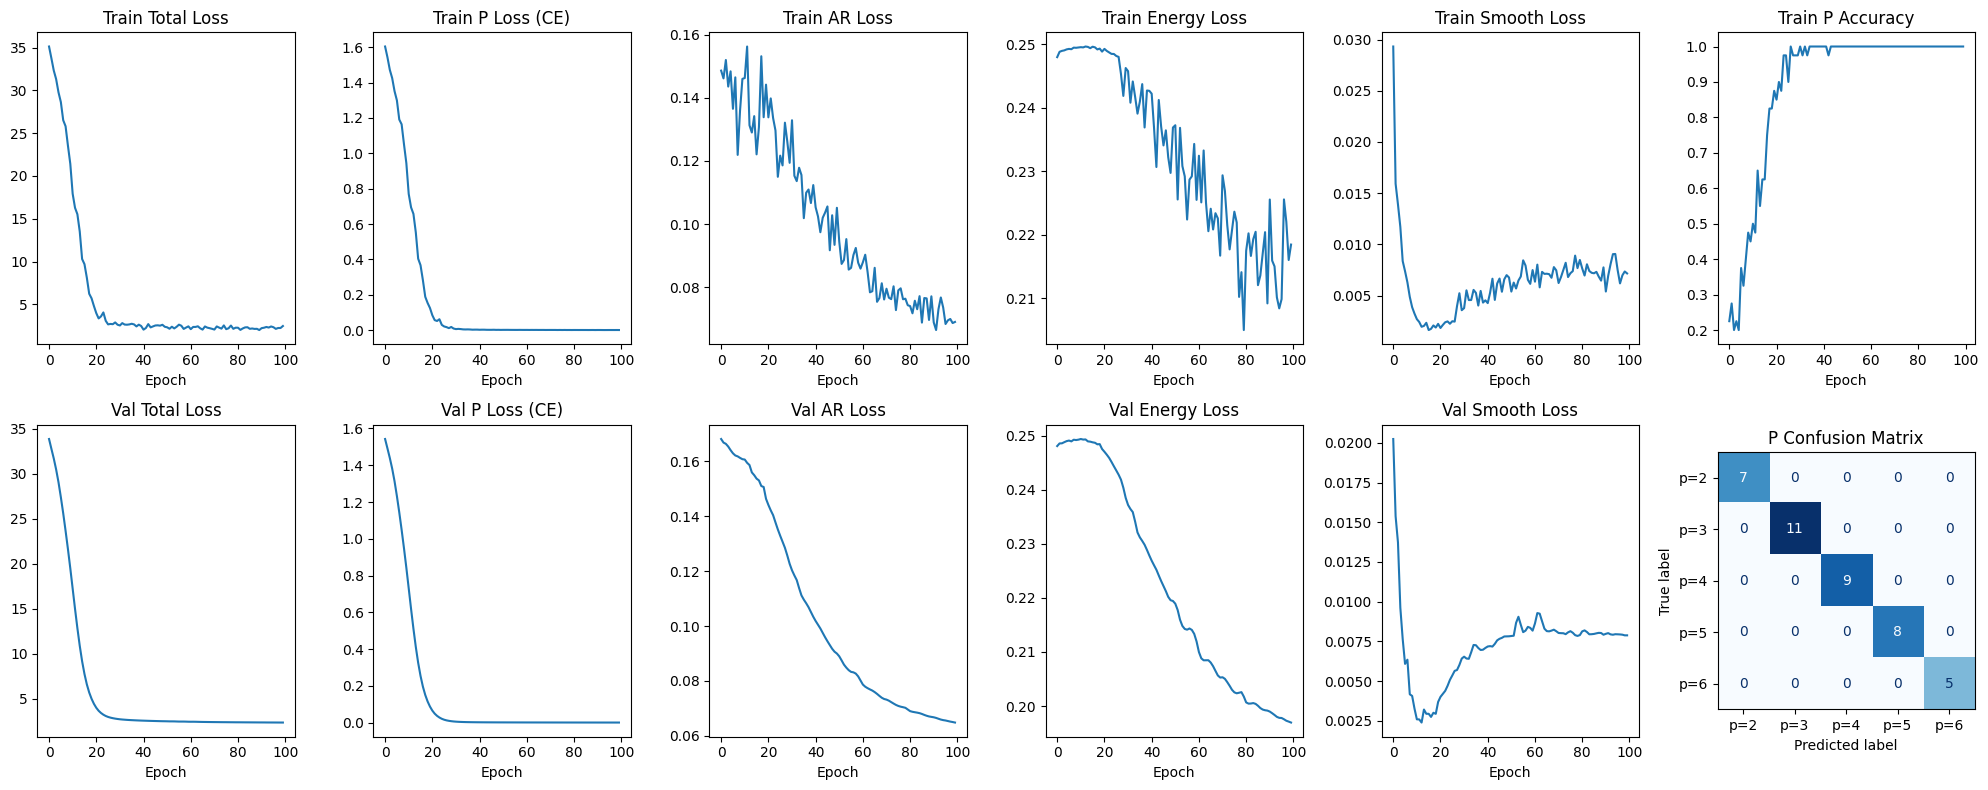

In [12]:
plot_history(history, model=model, val_loader=val_loader, device=device)

In [ ]:
def plot_coefficients_by_p(model, X, coeffs_true, p_true, device, p_max=6, p_min=2, title=""):
    model.eval()
    
    n_classes = p_max - p_min + 1  # 5 classes for p=2,3,4,5,6
    fig, axes = plt.subplots(1, n_classes, figsize=(4 * n_classes, 4))
    
    with torch.no_grad():
        for p_idx in range(n_classes):
            ax = axes[p_idx]
            p_actual = p_idx + p_min  # True AR order: 2,3,4,5,6
            
            mask = (p_true == p_idx).numpy() if torch.is_tensor(p_true) else (p_true == p_idx)
            if not mask.any():
                ax.set_title(f'p={p_actual} (no example)')
                continue
            
            idx = np.where(mask)[0][0]
            
            if torch.is_tensor(X):
                x = X[idx:idx+1].clone().detach().to(device)
            else:
                x = torch.from_numpy(X[idx:idx+1]).float().to(device)
            
            coeffs_pred, _, p_hard, _ = model(x)
            coeffs_pred = coeffs_pred.cpu().numpy()[0]  # (600, max_ar_order)
            p_pred = p_hard.item() + p_min  # Predicted AR order
            
            # Plot true coefficients (p_actual of them)
            for k in range(p_actual):
                label = 'True' if k == 0 else None
                ax.plot(coeffs_true[idx, :, k], 'k-', alpha=0.7, label=label)
            
            # Plot predicted coefficients (p_pred of them)
            for k in range(p_pred):
                label = 'Pred' if k == 0 else None
                ax.plot(coeffs_pred[:, k], color='darkred', alpha=0.7, label=label)
            
            ax.set_title(f'True p={p_actual}, Pred p={p_pred}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Coefficient')
            ax.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

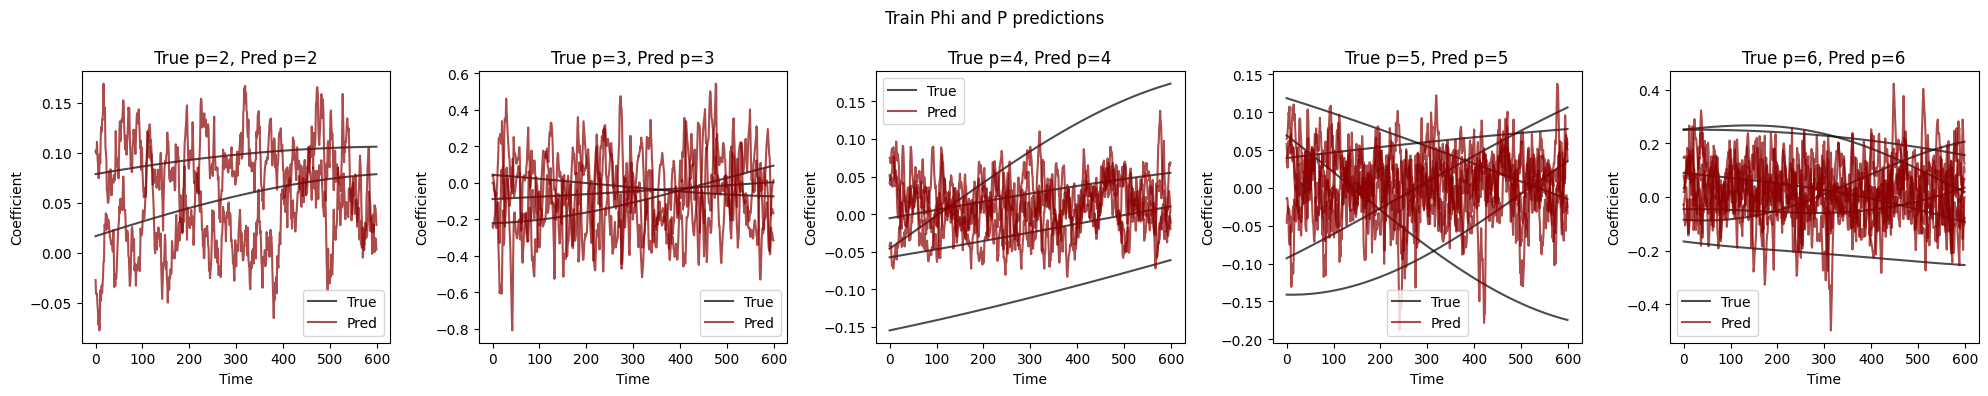

In [14]:
plot_coefficients_by_p(model, X_train, coef_train, p_train, device, title="Train Phi and P predictions")

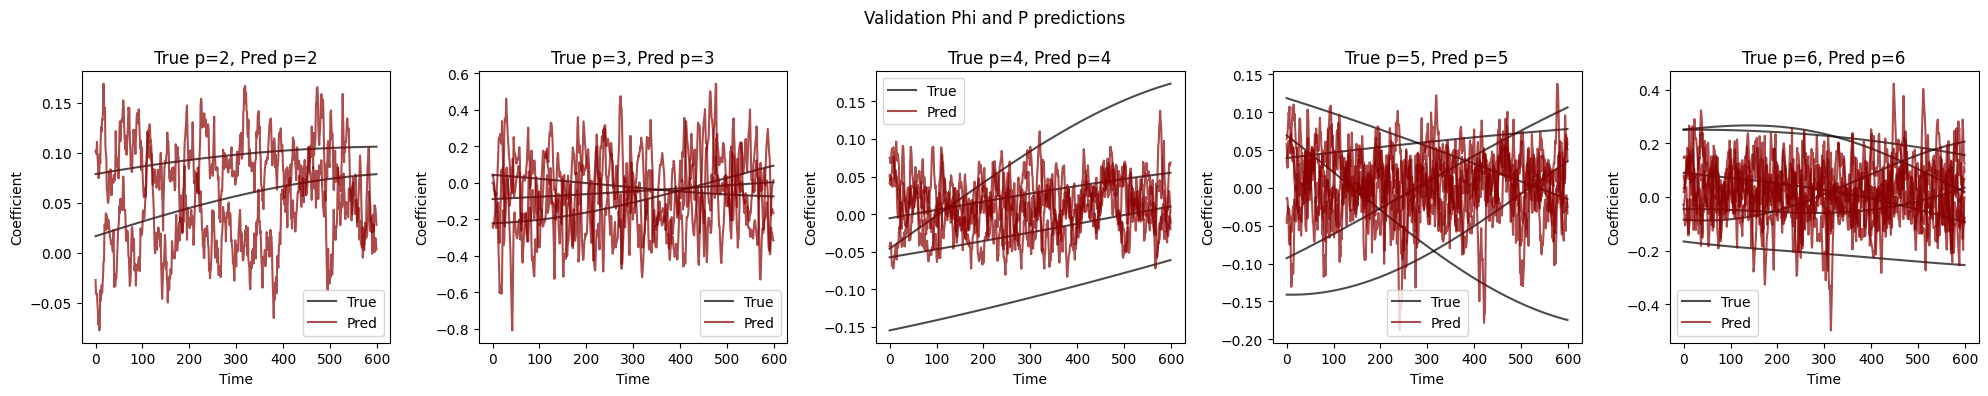

In [15]:
plot_coefficients_by_p(model, X_val, coef_val, p_val, device, title="Validation Phi and P predictions")

In [16]:
from stochastic_dynamics.models import AR
from stochastic_dynamics.embedders import embed


In [17]:
def fit_ar_model(xs, Fs, p=3, train_frac=0.9, refresh_every=5):
    X, y = AR.lag_matrix(xs, p)
    ntr = int(train_frac * len(y))
    X_tr, y_tr = X[:ntr], y[:ntr]
    w = AR.fit(X_tr, y_tr)
    N_te = len(y) - ntr
    t0 = p + ntr
    true_test = xs[t0 : t0 + N_te]
    yhat_ctrl = AR.hybrid_predict(xs, w, p, start_idx=t0, n_steps=N_te, refresh_every=refresh_every)
    full_pred = AR.hybrid_predict(xs, w, p, start_idx=p, n_steps=len(xs)-p, refresh_every=refresh_every)
    xs_pred_full = np.concatenate([xs[:p], full_pred])
    mse, mae, corr = AR.metrics(true_test, yhat_ctrl)
    return {
        'w': w, 'p': p, 'ntr': ntr, 'y': y, 'true_test': true_test,
        'yhat_ctrl': yhat_ctrl, 'xs_pred_full': xs_pred_full, 't0': t0,
        'mse': mse, 'mae': mae, 'corr': corr, 'refresh_every': refresh_every
    }


In [18]:
p3_indices = np.where(p_val.numpy() == 1)[0]
print(f"Found {len(p3_indices)} samples with p=3")

sample_idx = p3_indices[0] 

xs = X_val.cpu().numpy()[sample_idx]
Fs = 100

ar_results = fit_ar_model(xs, Fs, p=3, train_frac=0.9, refresh_every=5)

w = ar_results['w']
p_use = ar_results['p']
ntr = ar_results['ntr']
y = ar_results['y']
true_test = ar_results['true_test']
yhat_ctrl = ar_results['yhat_ctrl']
xs_pred_full = ar_results['xs_pred_full']
REFRESH_EVERY = ar_results['refresh_every']

print(f"AR({p_use}): MSE={ar_results['mse']:.6f}, corr={ar_results['corr']:.3f}")

Found 11 samples with p=3
AR(3): MSE=0.171524, corr=0.084


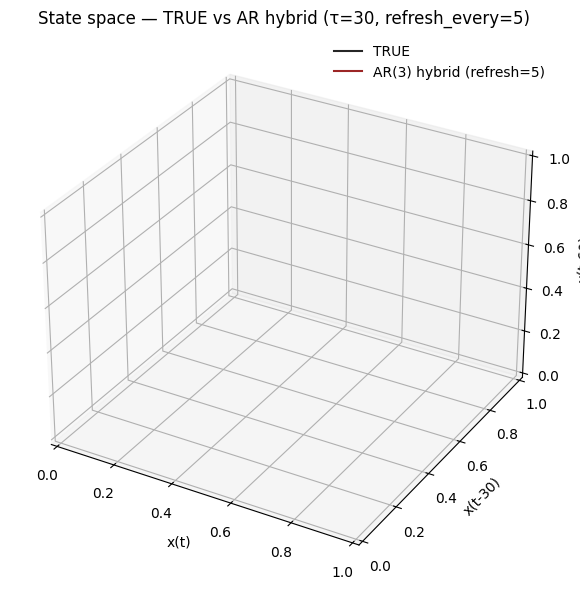

In [19]:
def plot_state_space(X3_true, X3_pred, p, tau, refresh, color_true="black", color_pred="darkred"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(X3_true[:,0], X3_true[:,1], X3_true[:,2], label="TRUE", color=color_true, alpha=0.85)
    ax.plot(X3_pred[:,0], X3_pred[:,1], X3_pred[:,2], label=f"AR({p}) hybrid (refresh={refresh})", color=color_pred, alpha=0.85)
    ax.set_title(f"State space — TRUE vs AR hybrid (τ={tau}, refresh_every={refresh})")
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t-{tau})")
    ax.set_zlabel(f"x(t-{2*tau})")
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

tau = 30
hy = yhat_ctrl - np.mean(yhat_ctrl)
hy = hy * (np.std(true_test) / (np.std(hy) + 1e-12)) + np.mean(true_test)

X3_true = embed(true_test, 3, tau)
X3_hyb = embed(hy, 3, tau)

plot_state_space(X3_true, X3_hyb, p_use, tau, REFRESH_EVERY)

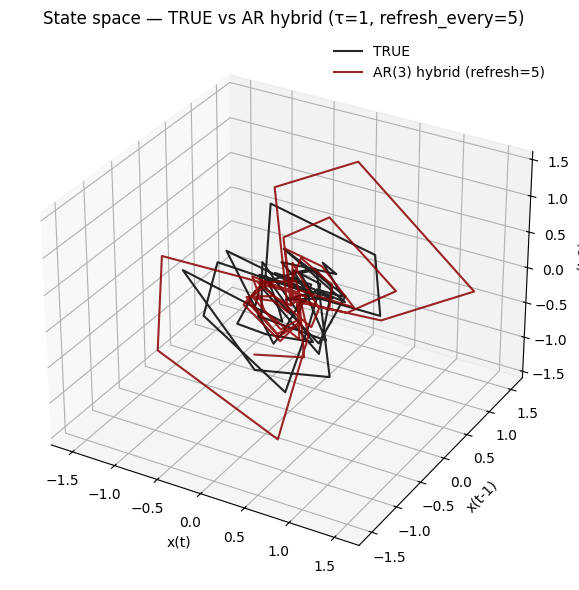

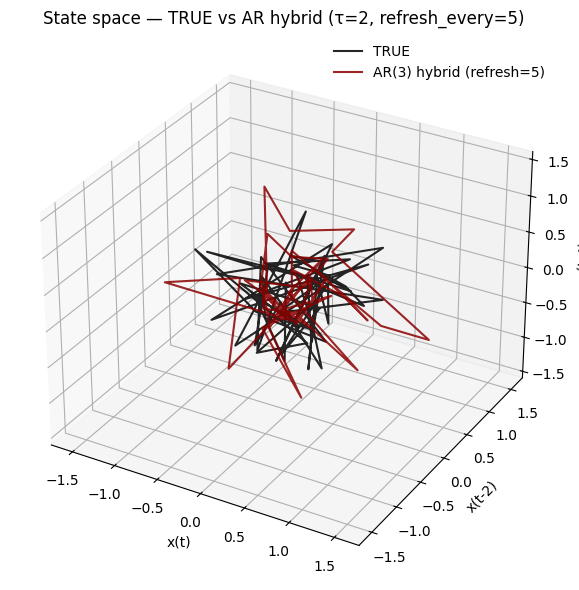

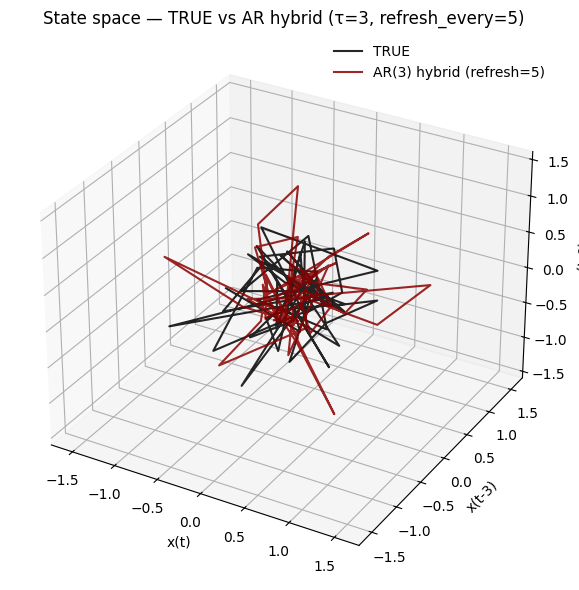

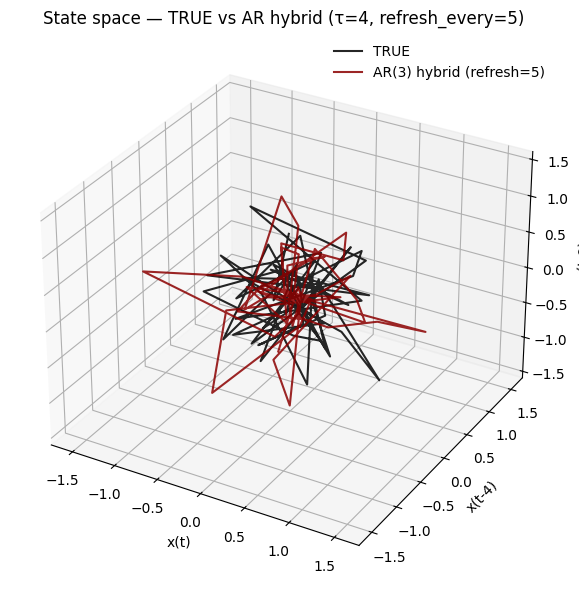

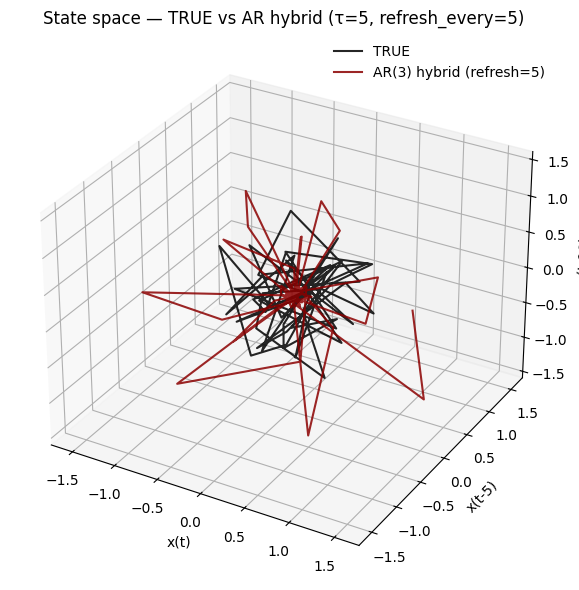

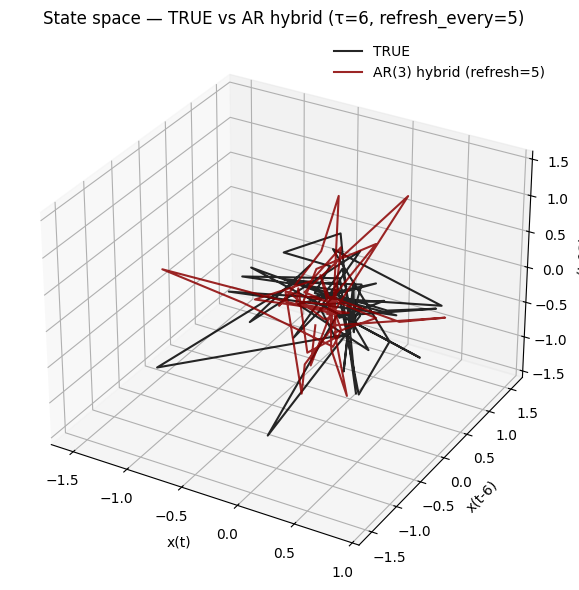

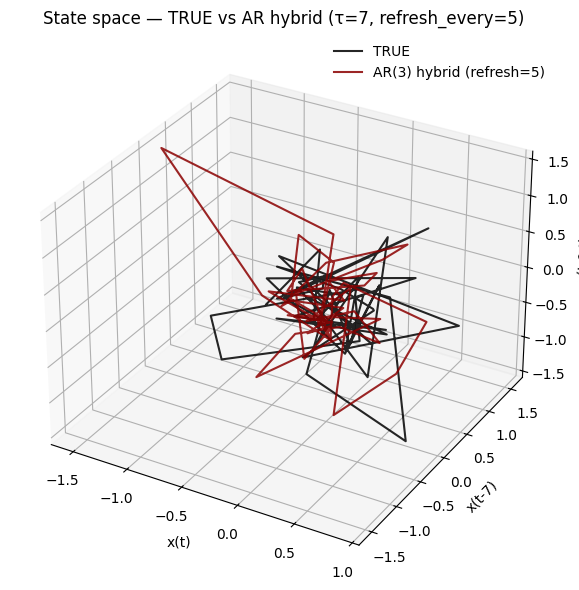

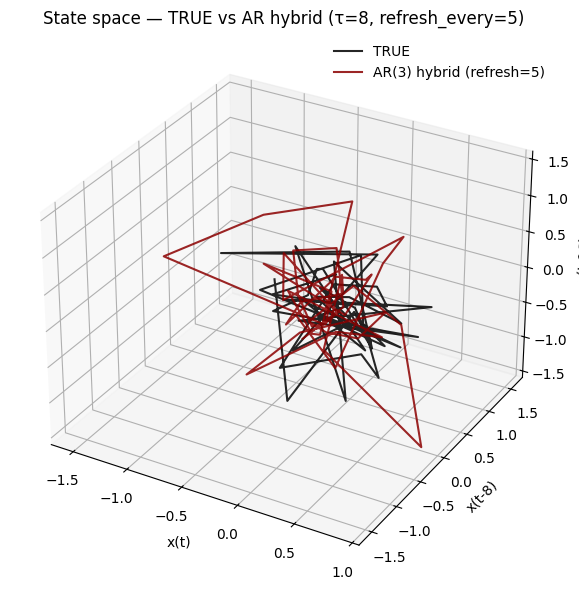

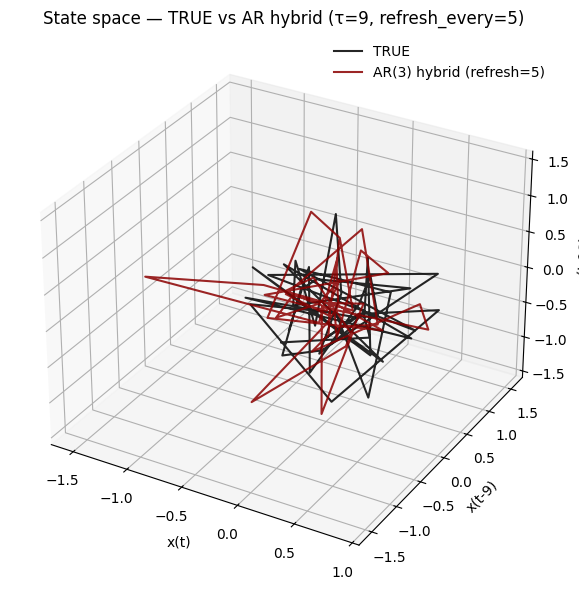

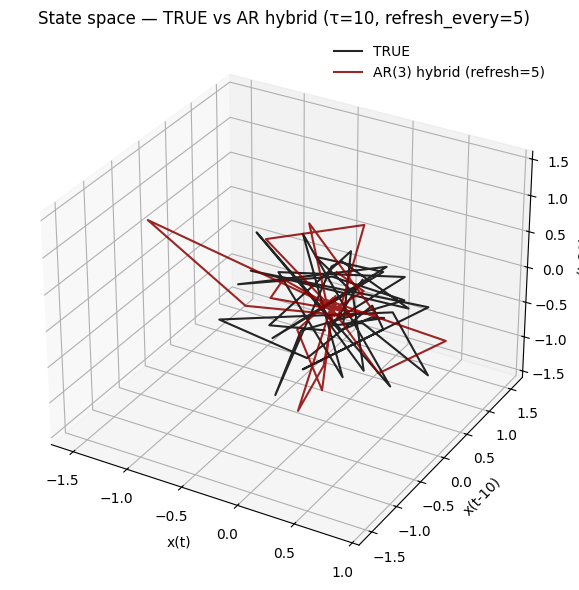

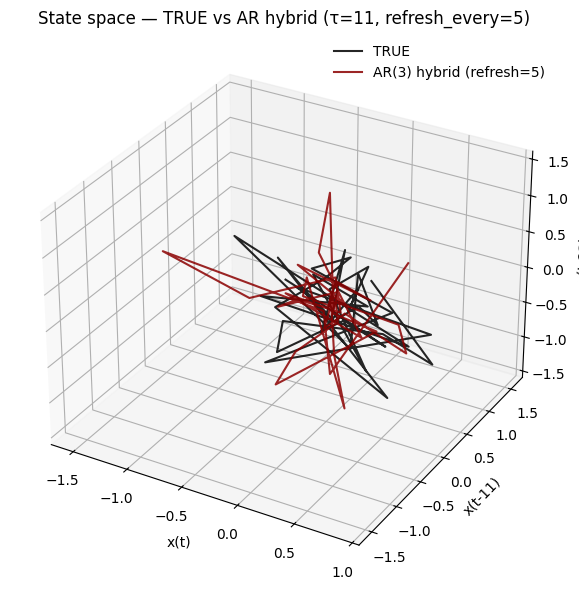

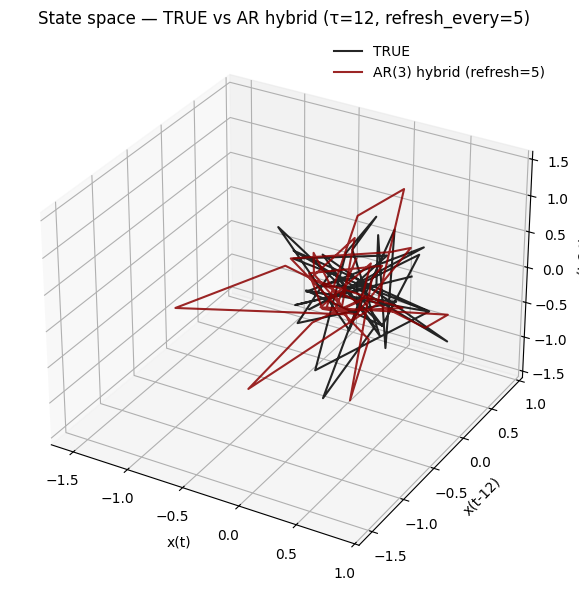

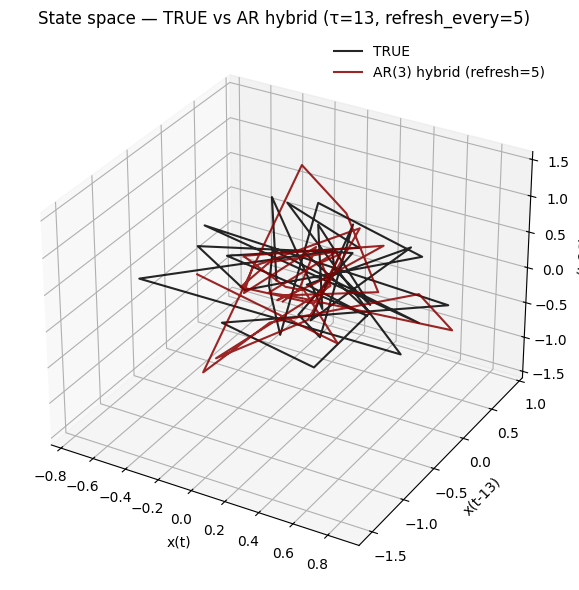

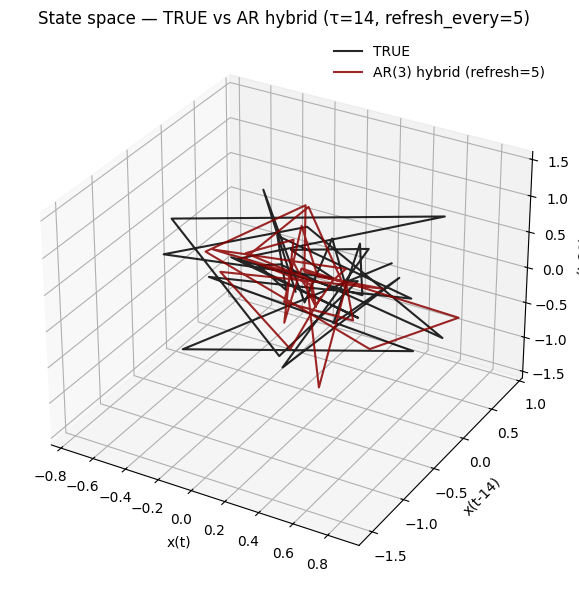

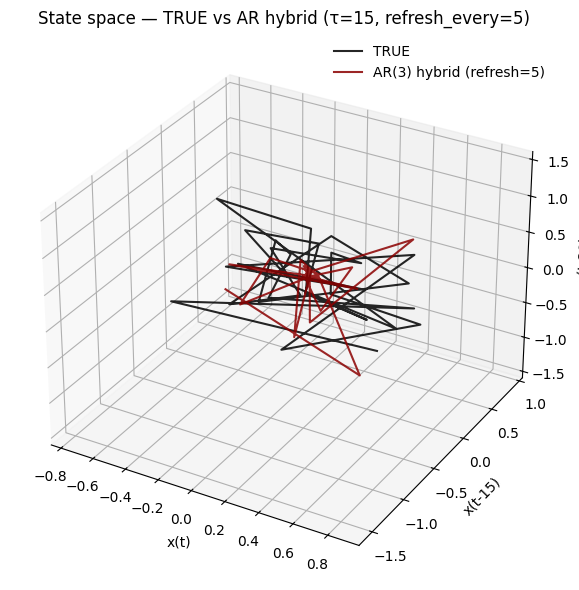

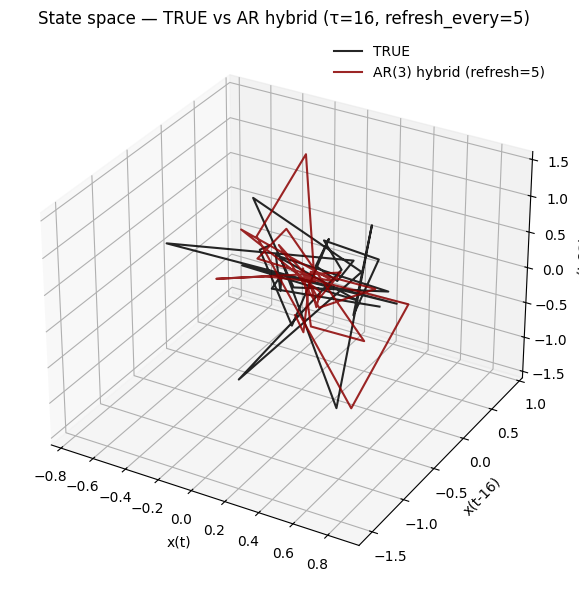

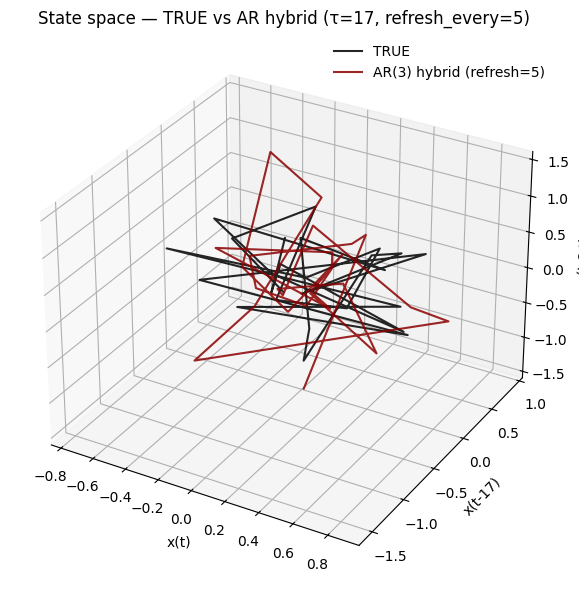

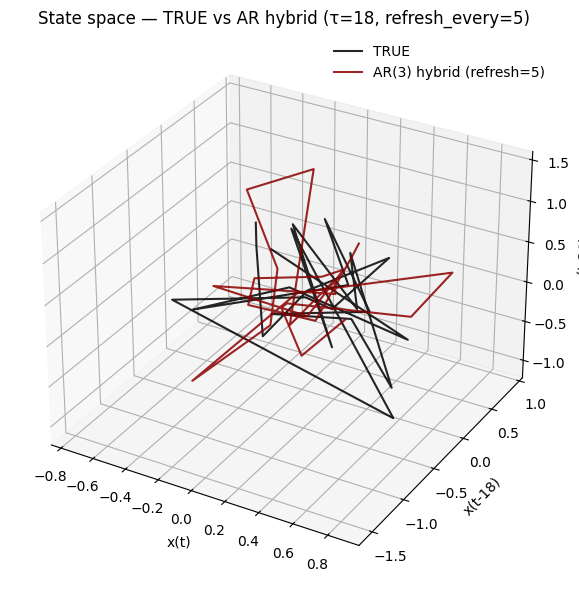

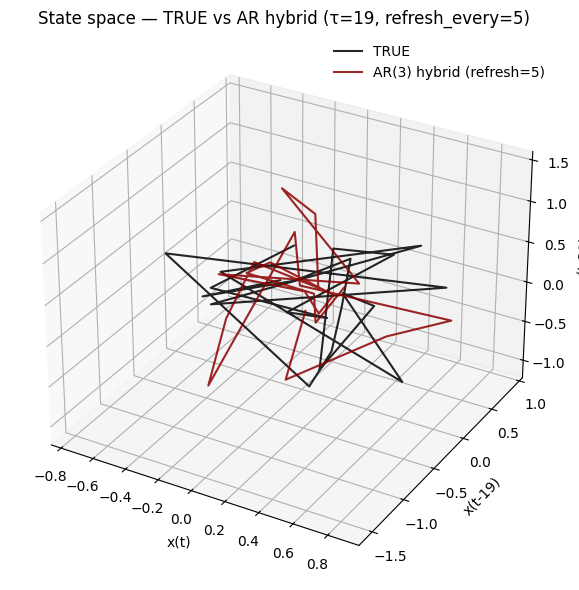

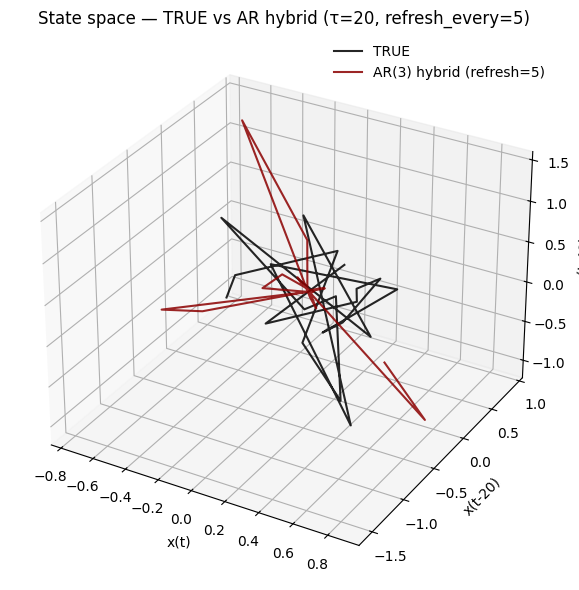

In [21]:
for tau in range (1, 21, 1):
    tau = tau
    hy = yhat_ctrl - np.mean(yhat_ctrl)
    hy = hy * (np.std(true_test) / (np.std(hy) + 1e-12)) + np.mean(true_test)

    X3_true = embed(true_test, 3, tau)
    X3_hyb = embed(hy, 3, tau)

    plot_state_space(X3_true, X3_hyb, p_use, tau, REFRESH_EVERY)